# Clusters
This notebook details the pipeline for clustering.

In [1]:
# Useful starting lines
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Load the data 
When loading the chord dataset, we can choose whether to keep sections in major or minor key, or both.

In [351]:
from load_data import load_chord_data, all_composers

In [344]:
# Optional parameter for load_chord_data: key_mode = 'both'/'major'/'minor'
chord_sentences = load_chord_data(all_composers, key_mode='minor')

## Apply Word2Vec
Several hyperparameters to choose.

In [345]:
from gensim.models import Word2Vec

In [346]:
# Ignore words with a lower frequency frequency than this
min_count = 5
# Size of the embedding space
size = 20
# Neighborhood of the focus word to study
window = 3
# 0 for CBOW, 1 for skip-gram
sg = 1
# Number of iterations (epochs)
iter = 500

# The first argument has to be a list of lists of words
w2v_model = Word2Vec(chord_sentences, min_count=min_count, size=size, window=window, sg=sg, iter=iter)

In [347]:
w2v_model.wv.vocab.keys()

dict_keys(['I:MIN', 'VI:MAJ', 'II:DIM', 'V:MAJ', '#VII:DIM', 'IV:MIN', 'III:MAJ', 'V:MIN', 'IV:MAJ', '#VI:DIM', 'VII:MAJ', 'II:MAJ', '#III:DIM', 'V:DIM', 'VII:MIN', 'I:MAJ', 'bII:MAJ', '#IV:DIM', 'II:MIN', '#I:DIM', '#VI:MAJ', '#VI:MIN', 'I:DIM', 'bV:MAJ', 'VII:DIM', 'IV:DIM', '#III:MIN', 'III:DIM', '#IV:MAJ', '##IV:DIM', 'VI:MIN', 'III:MIN', 'I:AUG', 'bVI:MAJ', 'VI:DIM', 'bVII:MIN', 'bII:AUG', '##VI:DIM', 'VI:AUG', '#VII:MAJ', 'bII:MIN', 'bVII:MAJ', '#II:DIM', 'bII:DIM', 'bIV:MAJ', '#VII:MIN', 'III:AUG', '#I:MAJ', '#IV:MIN', '#V:MAJ', '#V:DIM', 'bIII:MAJ', 'bI:MAJ', '#III:MAJ', 'bV:MIN', 'bV:DIM', 'bI:AUG', 'V:AUG', 'bI:MIN'])

## Isolate clusters, reduce dimensionality and visualise
We want to visualise the chord vectors and to find similarities among them.  
We isolate clusters, then we plot the dimensionality-reduced word vectors, highlighting the clusters by colour.

### Isolate clusters: K-means / Agglomerative

In [284]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from dimred_cluster import cluster_keyed_vec

#### Hyperparameter selection for k-means: n_clusters

In [285]:
from matplotlib import pyplot as plt

2  10  3  5  3  3  4  6  4  3  7  5  3  5  3  3  3  5  2  2  3  4  2  2  3  2  2  3  2  2  3  5  2  2  2  2  2  2  2  2  

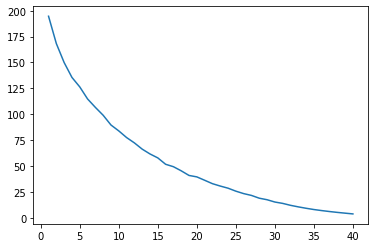

In [111]:
# The possible values of k
ks = range(1, 41)

inertias = []
for k in ks:
    kmeans = KMeans(n_clusters=k, tol=1e-10, n_init=100)
    wv_clus, clusters = cluster_keyed_vec(w2v_model.wv, kmeans, relabel=False)
    print(kmeans.n_iter_, ' ', end='')
    inertias.append(kmeans.inertia_)

plt.plot(ks, inertias)
# Hmmm, not that useful...

In [350]:
# Main hyperparameter: number of clusters
n_clusters = 29

#kmeans = KMeans(n_clusters=n_clusters)
agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
wv_clus, clusters, relabelling = cluster_keyed_vec(w2v_model.wv, agglomerative, relabel=True)

print(wv_clus, '\n')
for label in sorted(clusters.keys()):
    print(label, ':', clusters[label])
print('\n', relabelling, '\n')

{'I:MIN': 0, 'VI:MAJ': 0, 'II:DIM': 0, 'V:MAJ': 0, '#VII:DIM': 0, 'IV:MIN': 0, 'III:MAJ': 1, 'V:MIN': 1, 'IV:MAJ': 1, '#VI:DIM': 1, 'VII:MAJ': 1, 'II:MAJ': 1, '#III:DIM': 0, 'V:DIM': 0, 'VII:MIN': 2, 'I:MAJ': 0, 'bII:MAJ': 2, '#IV:DIM': 1, 'II:MIN': 1, '#I:DIM': 1, '#VI:MAJ': 4, '#VI:MIN': 4, 'I:DIM': 3, 'bV:MAJ': 3, 'VII:DIM': 5, 'IV:DIM': 10, '#III:MIN': 6, 'III:DIM': 5, '#IV:MAJ': 0, '##IV:DIM': 11, 'VI:MIN': 3, 'III:MIN': 3, 'I:AUG': 12, 'bVI:MAJ': 13, 'VI:DIM': 14, 'bVII:MIN': 15, 'bII:AUG': 16, '##VI:DIM': 7, 'VI:AUG': 2, '#VII:MAJ': 4, 'bII:MIN': 17, 'bVII:MAJ': 18, '#II:DIM': 7, 'bII:DIM': 19, 'bIV:MAJ': 8, '#VII:MIN': 6, 'III:AUG': 2, '#I:MAJ': 20, '#IV:MIN': 21, '#V:MAJ': 22, '#V:DIM': 23, 'bIII:MAJ': 24, 'bI:MAJ': 8, '#III:MAJ': 25, 'bV:MIN': 9, 'bV:DIM': 26, 'bI:AUG': 27, 'V:AUG': 28, 'bI:MIN': 9} 

0 : ['I:MIN', 'VI:MAJ', 'II:DIM', 'V:MAJ', '#VII:DIM', 'IV:MIN', '#III:DIM', 'V:DIM', 'I:MAJ', '#IV:MAJ']
1 : ['III:MAJ', 'V:MIN', 'IV:MAJ', '#VI:DIM', 'VII:MAJ', 'II:MAJ', '#IV

In [36]:
from visual import plot_dendrogram

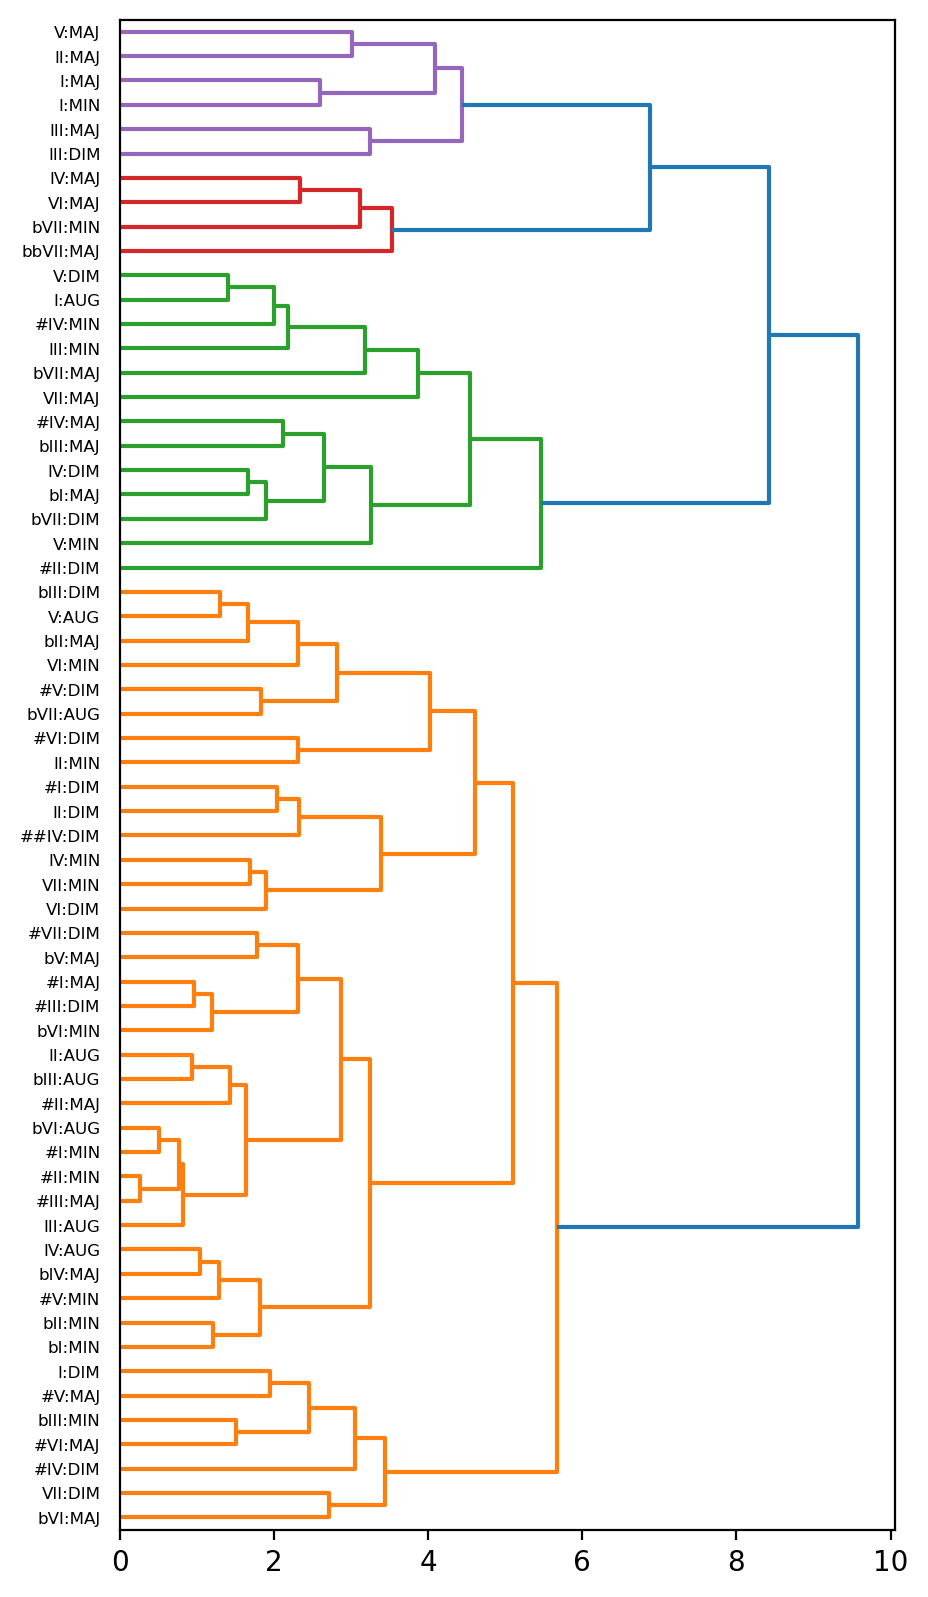

In [37]:
# Only works if agglomerative was constructed with n_clusters=None and min_distance=0
plot_dendrogram(agglomerative, leaf_label_func=lambda id : clusters[id][0], orientation='right')

### Reduce dimensionality: PCA / TSNE / Isomap

In [152]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
from dimred import dimred_keyed_vec

In [153]:
n_components = 2

pca = PCA(n_components=n_components)
#tsne = TSNE(n_components=n_components, learning_rate=100, n_iter=50000, n_iter_without_progress=10000)
#isomap = Isomap(n_components=n_components, metric='euclidean')
wv_red = dimred_keyed_vec(w2v_model.wv, pca.fit_transform, comps_to_keep=[0,1])

In [154]:
print(pca.components_[0])
print(pca.components_[1])
print(pca.explained_variance_ratio_)

[ 0.24815442 -0.12381814 -0.28823994  0.38264652 -0.19047688  0.31323579
  0.06919133 -0.29246081  0.07114592  0.23561461 -0.13774526  0.04160768
  0.34530125  0.11629943  0.5048064 ]
[-0.13174353  0.41542958 -0.18359655  0.13756545 -0.10169214  0.00708774
 -0.06888952  0.45116993 -0.15187647  0.03861462  0.43491141 -0.19603118
 -0.21520474 -0.06462172  0.48591727]
[0.32269572 0.21910786]


### Visualise
Scatter dimensionality-reduced points.  
The shape of the marker indicates the key mode of the section containing the chord (major/minor/unspecified).  
The colour of the marker indicates the cluster label.

In [155]:
from visual import visual_chord_vectors_clusters

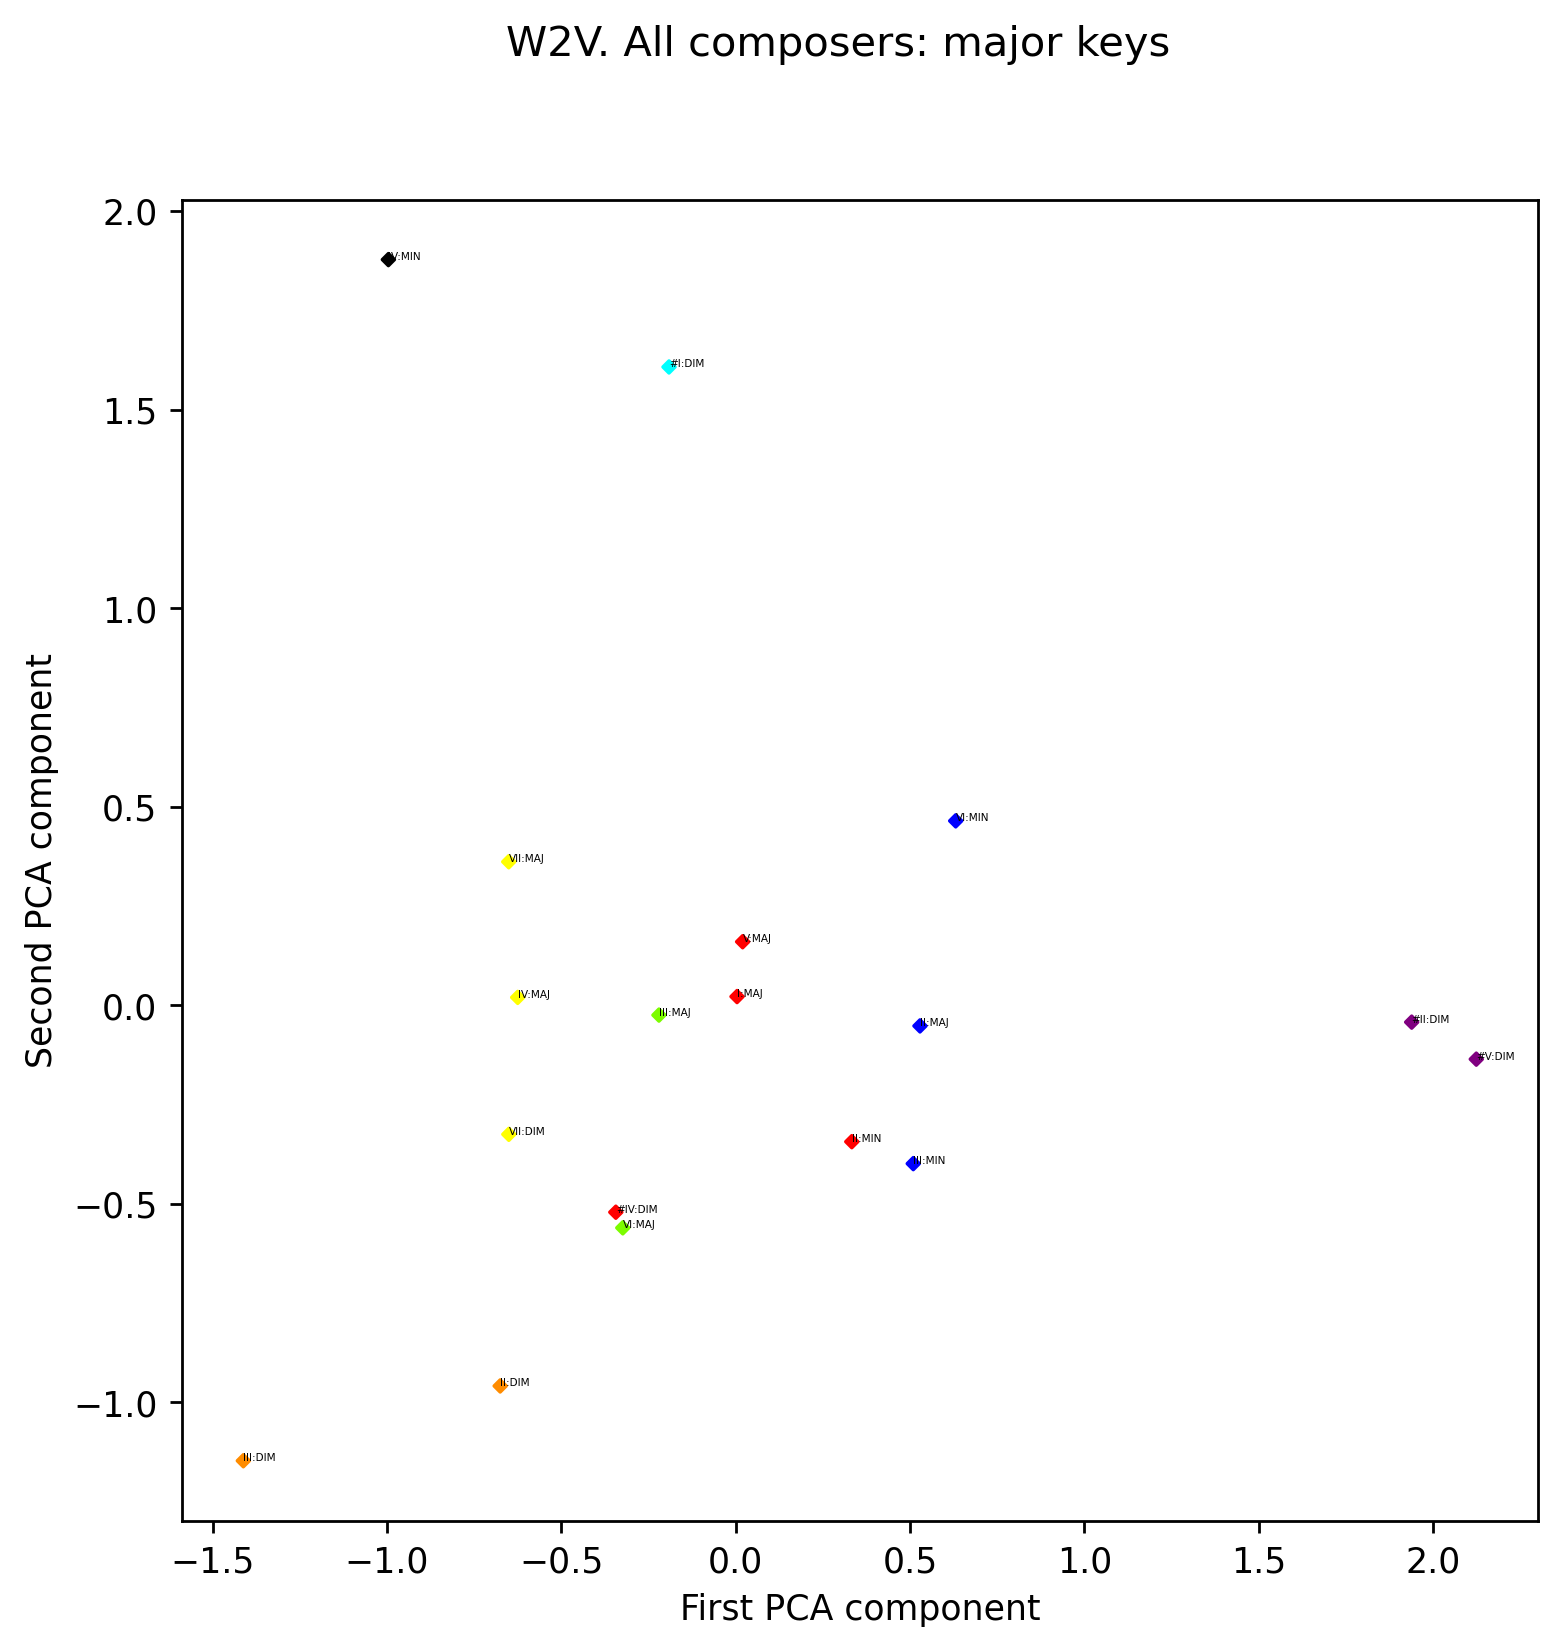

In [156]:
visual_chord_vectors_clusters(wv_red=wv_red, wv_clus=wv_clus, dimred_method='PCA', 
                             plot_title='W2V. All composers: major keys', 
                             chord_types_to_label=[':'], chord_types_not_to_label=[], 
                             marker_size=6, label_size=3, remove_key_mode=True, figsize=(7, 7), dpi=250)

## Investigate similarities

In [356]:
w2v_model.wv.similarity('I:MIN', 'V:MAJ')

0.91645074

In [357]:
from print_similarities import print_similarities

In [359]:
print_similarities(w2v_model, chord_types_to_print=[''])

##IV:DIM: (bII:AUG, 0.472), (I:MIN, 0.439), (IV:MIN, 0.432), (II:DIM, 0.431),
##VI:DIM: (#II:DIM, 0.713), (#VII:MAJ, 0.644), (#I:DIM, 0.561), (#VI:MIN, 0.531),
#I:DIM: (#IV:DIM, 0.606), (II:MAJ, 0.566), (##VI:DIM, 0.561), (II:MIN, 0.512),
#I:MAJ: (#V:MAJ, 0.507), (#V:DIM, 0.471), (IV:MAJ, 0.386), (IV:DIM, 0.377),
#II:DIM: (##VI:DIM, 0.713), (#III:MIN, 0.624), (#VII:MIN, 0.604), (#IV:DIM, 0.541),
#III:DIM: (V:DIM, 0.668), (#VII:DIM, 0.633), (IV:MIN, 0.627), (I:MAJ, 0.609),
#III:MAJ: (#VI:MIN, 0.593), (V:AUG, 0.556), (#VII:MAJ, 0.544), (##VI:DIM, 0.473),
#III:MIN: (#II:DIM, 0.624), (#VII:MIN, 0.595), (#VII:MAJ, 0.564), (V:AUG, 0.509),
#IV:DIM: (II:MAJ, 0.744), (V:MAJ, 0.651), (#VII:DIM, 0.650), (#I:DIM, 0.606),
#IV:MAJ: (V:MAJ, 0.574), (#VII:DIM, 0.565), (bV:DIM, 0.531), (bII:MIN, 0.497),
#IV:MIN: (#V:MAJ, 0.478), (V:MIN, 0.439), (#III:DIM, 0.405), (III:MAJ, 0.405),
#V:DIM: (#VII:MAJ, 0.474), (#I:MAJ, 0.471), (#III:MAJ, 0.464), (#V:MAJ, 0.451),
#V:MAJ: (#I:MAJ, 0.507), (##VI:DIM, 0.494),